# Exercise

In this exercise we are going to use pydantic AI with Google Gemini to analyze an image of a wire and determine if it is broken or not. Then, depending on the result, we take one of two actions: we either send an email to the QA team telling them that the wire is broken, or we don't and we ship the wire to the customer.

## Setup

First, make sure you have setup your credentials like this:

```bash
cp env.example .env
```

Then open .env and insert your API key for Gemini, like this:

```yaml
GEMINI_API_KEY=[your key]
...
```
while leaving the rest untouched.

Then we can load the credentials like this:

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

Since Pydantic AI uses asyncio (asyncronous code), we need to do use nest_asyncio to be able to work in Jupyter:

**NOTE**: this is not necessary if you are writing scripts. Also, if you know how to use asyncio in python, you can use the async version of pydantic AI (i.e., change all the calls to `run_sync` to `await run(...)` in the following code and you can then insert it in your async codebase)

In [2]:
import nest_asyncio

# TODO: use apply to make sure you can use Pydantic AI
# in jupyter
nest_asyncio.apply()

Let's first create some utilities that we will use later:

In [3]:

from PIL import Image
import matplotlib.pyplot as plt
    

def display_image_with_caption(image: Image.Image, caption: str):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, wrap=True, fontsize=8, pad=20)
    plt.tight_layout()
    plt.show()

## Image analysis with Pydantic AI and Gemini

Let's use Pydantic AI and Gemini to do some image analysis.

=== Image Analysis Results ===
{
    "status": "not_intact",
    "description": "The image shows a damaged black cable with exposed copper wires due to a significant break in its outer insulation."
}


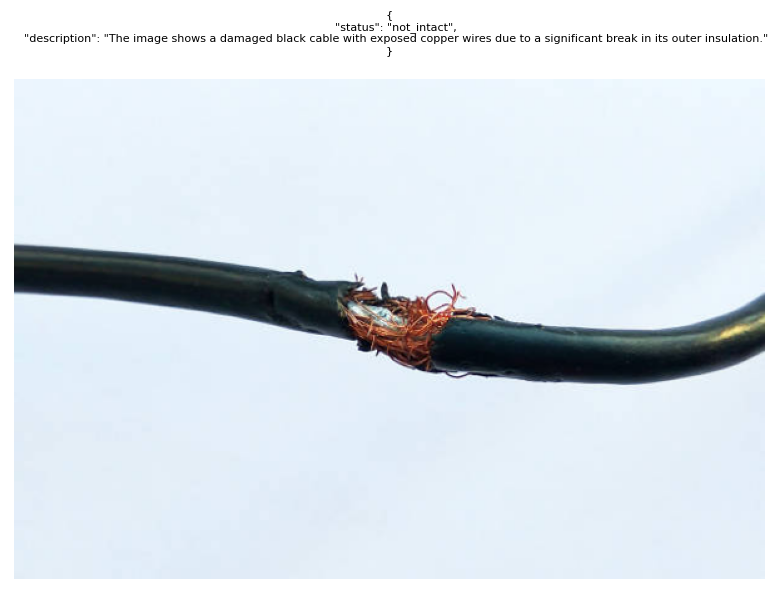

In [5]:

from pydantic import BaseModel
from typing import Literal
from pydantic_ai import Agent
from pydantic_ai.messages import BinaryContent
from io import BytesIO


# TODO: write a pydantic model describing the schema of the output.
# Include a docstring with our prompt:
# "Detect whether the write is intact or not, and describe the picture."
# The output schema should have the following elements:
# * `status`, which can only take the values "intact", "not_intact"
# * `description` with a type of str
class ImageAnalysis(BaseModel):
    """
    Detect whether the write is intact or not, and describe the picture.
    """
    status: Literal["intact", "not_intact"]
    description: str


# TODO: Create agent with structured output
# Use the google-gla:gemini-2.5-flash model and a relevant system prompt.
agent = Agent(
    'google-gla:gemini-2.5-flash',
    output_type=ImageAnalysis,
    system_prompt=(
        "You are an expert image analyst. Analyze images and provide structured output. "
    )
)


def analyze_image_with_structured_output(img: Image.Image) -> ImageAnalysis:
    
    # Limit size to reduce token usage
    img.thumbnail((600, 600))
    
    # Encode image in a BinaryContent instance
    image_bytes = BytesIO()
    img.save(image_bytes, format='JPEG')
    binary_content = BinaryContent(data=image_bytes.getvalue(), media_type='image/jpeg')
    
    # TODO: run analysis
    result = agent.run_sync(
        [
            binary_content
        ],
    )
    
    return result.output

# Analyze image with structured output

# TODO: load the "wire.jpg" image using pillow
image = Image.open("wire.jpg")
# TODO: run the analysis using the function we just wrote
analysis = analyze_image_with_structured_output(image)

# The output is an instance of our output model. We can pretty-print it
# using json
print("=== Image Analysis Results ===")
print(analysis.model_dump_json(indent=4))

display_image_with_caption(image, analysis.model_dump_json(indent=4))


In [8]:
def send_alert_to_qa_team(description: str):
    email = f"""
    From: automatic quality assurance

    The wire looks broken. Report:

    {description}
    """
    # We don't really send an email
    print(email)


def mark_for_shipping():
    # ...
    pass

# TODO: write some python code to implement the following
# logic: if the wire is not_intact, call the send_alert_to_qa_team function,
# otherwise call mark_for_shipping
if analysis.status == "not_intact":
    send_alert_to_qa_team(analysis.description)
else:
    mark_for_shipping()



    From: automatic quality assurance

    The wire looks broken. Report:

    The image shows a damaged black cable with exposed copper wires due to a significant break in its outer insulation.
    
